Tests for mod_mod algo

In [1]:
import torch
from torch import distributions as dist

import itertools
import pickle
import importlib

import itertools
import random
import math
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')
sns.set_context('paper')
# Plot adjustments:
plt.rcParams.update({'ytick.labelsize': 15})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'axes.labelsize': 20})
plt.rcParams.update({'legend.fontsize': 12})
plt.rcParams.update({'axes.titlesize': 16})
from gptorch import kernels, models
import helpers, opt, objectives

In [2]:
torch.set_default_tensor_type(torch.DoubleTensor)

In [49]:
aas = 'AB'
n_aas = 2
L = 15

dic = {
    'A' * L: torch.tensor(0.99),
    'B' * L: torch.tensor(0.95)
}

torch.manual_seed(0)
for k in itertools.product(aas, repeat=L):
    k = ''.join(k)
    if k in dic:
        continue
    elif k[:3] == 'AAA':
        dic[k] = torch.rand([])
    elif k[-3:] == 'BBBB':
        dic[k] = torch.rand([])
    elif k[4:10] == 'ABBABB':
        dic[k] = torch.rand([])
    else:
        dic[k] = torch.tensor(0.0)
        
ns = [2, 500, 1000, 2000]

In [33]:
ground = [(aa, i) for aa in aas for i in range(L)]

In [34]:
seed = helpers.get_seed(dic)
seed

[('B', 0),
 ('B', 1),
 ('B', 2),
 ('B', 3),
 ('A', 4),
 ('B', 5),
 ('B', 6),
 ('A', 7),
 ('B', 8),
 ('B', 9),
 ('B', 10),
 ('A', 11),
 ('A', 12),
 ('B', 13),
 ('A', 14)]

In [35]:
def ddr(x, n):
    return n * (n - 2 * x + 1) * (1 - 1 / x) ** n / (x - 1) ** 2 / x ** 2

def get_alpha(dic, n):
    probs = np.sort(np.array([dic[k] for k in dic]))
    L = len(next(iter(dic.keys())))
    S = len(probs)
    alpha = 0
    for s in range(1, S):
        if s % 1000 == 0:
            print(s)
        candidate = (1 - (1 - 1 / (2 * s)) ** n) - (1 - (1 - 1 / s) ** n)
        candidate *= np.sum(probs[:S])
        if candidate <= alpha:
            alpha = candidate
        else:
            break
    return alpha

In [36]:
np.random.seed(402136)

M = [[int(np.random.random() * 2 + 1) for _ in range(L)] for _ in range(3)]
inds = [[np.random.choice(n_aas, m, replace=False) * L + i for i, m in enumerate(mm)] for mm in M]
inds = [list(itertools.chain.from_iterable(ind)) for ind in inds]
libs = [[ground[i] for i in lib] for lib in inds]
libs
starts = [seed, ground]
starts += [lib for lib in libs]
for s in starts:
    print(helpers.get_N(s, L))
# starts = [seed, ground]
# for m in [10, 15, 20]:
#     A = np.random.choice(L * n_aas, m, replace=False)
#     A = [ground[a] for a in A]
#     starts.append(A)


1
32768
32
128
1024


In [50]:
def ddr(x, n):
    return n * (n - 2 * x + 1) * (1 - 1 / x) ** n / (x - 1) ** 2 / x ** 2

alphas = [scipy.optimize.minimize(ddr, 500, args=(n,), method='Powell')['fun'] for n in ns]
alphas = [-torch.Tensor(alpha) for alpha in alphas]
alphas

[tensor(0.1250), tensor(1.00000e-06 *
        1.6797), tensor(1.00000e-07 *
        4.1994), tensor(1.00000e-07 *
        1.0498)]

In [40]:
def get_alpha(dic, n):
    probs = np.sort(np.array([dic[k] for k in dic]))
    L = len(next(iter(dic.keys())))
    S = len(probs)
    alpha = 0
    for s in range(1, S):
        if s % 1000 == 0:
            print(s)
        candidate = (1 - (1 - 1 / (2 * s)) ** n) - (1 - (1 - 1 / s) ** n)
        candidate *= np.sum(probs[:S])
        if candidate <= alpha:
            alpha = candidate
        else:
            break
    return alpha

    
%time alphas2 = [-get_alpha(dic, n) for n in ns]
alphas2

1000
CPU times: user 470 ms, sys: 5.91 ms, total: 476 ms
Wall time: 474 ms


[711.1050353969392, 569.4310849076033, 569.1574254840262, 569.020716704798]

In [41]:
S = L * n_aas
S = torch.tensor(S).double()
beta = 2 * torch.sqrt(S - 1) - torch.sqrt(S) - torch.sqrt(S - 2)

In [51]:
df = pd.DataFrame(columns=['n', 'start', 'L', 'algorithm', 'obj'])

In [52]:
%%time
for n in ns:
    for S in starts:
        _, objs = opt.greedy(ground, S, objectives.objective, obj_args=(L, dic, n))
        other = pd.DataFrame([[n, S, L, 'gr', objs[-1]]], columns=df.columns)
        df = df.append(other)
        
for n in ns:
    for S in starts:
        _, objs = opt.greedy_add(ground, S, objectives.objective, obj_args=(L, dic, n))
        other = pd.DataFrame([[n, S, L, 'gr_add', objs[-1]]], columns=df.columns)
        df = df.append(other)
        

for n in ns:
    for S in starts:
        _, objs = opt.greedy_add(ground, S, objectives.objective, obj_args=(L, dic, n), remove=True)
        other = pd.DataFrame([[n, S, L, 'gr_rem', objs[-1]]], columns=df.columns)
        df = df.append(other)

CPU times: user 9.58 s, sys: 56.7 ms, total: 9.63 s
Wall time: 9.67 s


In [53]:
%%time
opt = importlib.reload(opt)
dc_list = []

for alpha, n in zip(alphas, ns):
    print(n)
    for S in starts:
        X_list, objs = opt.mod_mod(ground, S, objectives.objective, args=(L, dic, n), dec='dc', alpha=alpha,
                            beta=beta, verbose=False)
        other = pd.DataFrame([[n, S, L, 'SS-dc', objs[-1]]], columns=df.columns)
        df = df.append(other)
        dc_list.append([S, X_list, n, alpha])

2
500
1000
2000
CPU times: user 39min 16s, sys: 1min 55s, total: 41min 11s
Wall time: 47min 41s


In [54]:
%%time
opt = importlib.reload(opt)
ds_list = []

for alpha, n in zip(alphas2, ns):
    print(n)
    for S in starts:
        X_list, objs = opt.mod_mod(ground, S, objectives.objective, args=(L, dic, n), dec='dc', alpha=alpha,
                            beta=beta, verbose=False)
        other = pd.DataFrame([[n, S, L, 'SS-ds', objs[-1]]], columns=df.columns)
        df = df.append(other)
        ds_list.append([S, X_list, n, alpha])

2
500
1000
2000
CPU times: user 39min 6s, sys: 1min 59s, total: 41min 6s
Wall time: 46min 44s


In [55]:
# Fix the SS vs MM
to_replace = ['SS-dc', 'SS-ds', 'gr', 'gr_add', 'gr_rem']
values = ['LBDC', 'LBDS', 'greedy', 'add', 'rem']
df['algorithm'] = df['algorithm'].replace(to_replace=to_replace, value=values)

In [56]:
results = {
    'df':df,
    'ds_list': ds_list,
    'dc_list': dc_list
}

with open('../outputs/20181018_synthetic_opt15.pkl', 'wb') as f:
    pickle.dump(results, f)

In [57]:
with open('../outputs/20181018_synthetic_opt15.pkl', 'rb') as f:
    results = pickle.load(f)
df = results['df']

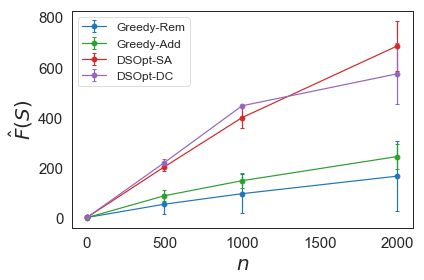

In [68]:
fig, ax = plt.subplots(1, 1)
pal = sns.color_palette()
lab_dict = {
    'greedy': 'Greedy',
    'add': 'Greedy-Add', 
    'rem': 'Greedy-Rem',
    'LBDS': 'DSOpt-SA',
    'LBDC': 'DSOpt-DC'
}
for c, al in zip(pal, sorted(set(df['algorithm']))[::-1]):
    if al == 'greedy':
        continue
    df_ = df[df['algorithm'] == al]
    means = [np.mean(df_[df_['n'] == n]['obj']) for n in ns]
    stds = [np.std(df_[df_['n'] == n]['obj']) for n in ns]
    maxes = [np.max(df_[df_['n'] == n]['obj']) for n in ns]
    mins = [np.min(df_[df_['n'] == n]['obj']) for n in ns]
#     _ = ax.plot(ns, mins, color=c)
    _ = ax.errorbar(ns, -np.array(means), yerr=stds / np.sqrt(len(starts)), fmt='-o', 
                    label=lab_dict[al], capsize=2, color=c)
#     _ = ax.fill_between(ns, maxes, mins, color=c, alpha=0.3)
_ = ax.set_xlabel(r'$n$')
_ = ax.set_ylabel(r'$\hat{F}(S)$')
_ = ax.legend()
_ = fig.tight_layout()
_ = fig.savefig('../outputs/synthetic_objectives15.pdf')

In [67]:
df[df['algorithm'] == 'greedy']

,n,start,L,algorithm,obj
0,2,"[(B, 0), (B, 1), (B, 2), (B, 3), (A, 4), (B, 5...",15,greedy,tensor(-1.3102)
0,2,"[(A, 0), (B, 0), (A, 1), (B, 1), (A, 2), (B, 2...",15,greedy,tensor(-1.4394)
0,2,"[(A, 0), (B, 1), (B, 2), (A, 2), (B, 3), (A, 4...",15,greedy,tensor(-1.3533)
0,2,"[(A, 0), (B, 0), (A, 1), (A, 2), (B, 3), (A, 3...",15,greedy,tensor(-1.4835)
0,2,"[(B, 0), (A, 0), (B, 1), (A, 2), (B, 2), (B, 3...",15,greedy,tensor(-1.5904)
0,500,"[(B, 0), (B, 1), (B, 2), (B, 3), (A, 4), (B, 5...",15,greedy,tensor(-153.0064)
0,500,"[(A, 0), (B, 0), (A, 1), (B, 1), (A, 2), (B, 2...",15,greedy,tensor(-236.7804)
0,500,"[(A, 0), (B, 1), (B, 2), (A, 2), (B, 3), (A, 4...",15,greedy,tensor(-236.7804)
0,500,"[(A, 0), (B, 0), (A, 1), (A, 2), (B, 3), (A, 3...",15,greedy,tensor(-236.7804)
0,500,"[(B, 0), (A, 0), (B, 1), (A, 2), (B, 2), (B, 3...",15,greedy,tensor(-236.7804)
